In [1]:
import numpy as np
import geopandas as gpd
import rioxarray as rioxr
import matplotlib.pyplot as plt

from shapely.geometry import Polygon 

# library to access catalog
from pystac_client import Client
# used to sign items from the MPC STAC catalog 
import planetary_computer

from IPython.display import Image


In [2]:
# access the catalog
catalog = Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier = planetary_computer.sign_inplace)

# make list of collections
collections = list(catalog.get_collections())

# get modis veg 
modis_col = catalog.get_child('modis-13A1-061')


In [3]:
modis_col


<CollectionClient id=modis-13A1-061>

In [6]:
# make bounding box
bbox = {
    "type": "Polygon",
    "coordinates":[
        [
            [-119.28376473993174, 35.561681976121605],
            [-119.28376473993174, 36.65291223580975],
            [-117.15965333370627, 36.65291223580975],
            [-117.15965333370627, 35.561681976121605],
            [-119.28376473993174, 35.561681976121605]
        ]
    ],
}

# make search within the specified area
search = catalog.search(
    collections = ['modis-13A1-061'], # list with collection IDs
    intersects = bbox, 
    datetime = "2023"
)


In [8]:
items = search.item_collection()

# select the first item in the list of items
item = items[0]

In [25]:
# print dictionary of properties associated with item
item.properties

print(f" datetime: {item.properties['datetime']}" )
print(f" start_datetime: {item.properties['start_datetime']}" )     
print(f" end_datetime': {item.properties['end_datetime']}")   

 datetime: None
 start_datetime: 2023-11-09T00:00:00Z
 end_datetime': 2023-11-24T23:59:59Z


In [26]:
for key, asset in item.assets.items():
    print(key, '-', asset.title)

hdf - Source data containing all bands
metadata - Federal Geographic Data Committee (FGDC) Metadata
500m_16_days_EVI - 500m 16 days EVI
500m_16_days_NDVI - 500m 16 days NDVI
500m_16_days_VI_Quality - VI quality indicators
500m_16_days_MIR_reflectance - Surface Reflectance Band 7
500m_16_days_NIR_reflectance - Surface Reflectance Band 2
500m_16_days_red_reflectance - Surface Reflectance Band 1
500m_16_days_blue_reflectance - Surface Reflectance Band 3
500m_16_days_sun_zenith_angle - Sun zenith angle of VI pixel
500m_16_days_pixel_reliability - Quality reliability of VI pixel
500m_16_days_view_zenith_angle - View zenith angle of VI Pixel
500m_16_days_relative_azimuth_angle - Relative azimuth angle of VI pixel
500m_16_days_composite_day_of_the_year - Day of year VI pixel
tilejson - TileJSON with default rendering
rendered_preview - Rendered preview


In [34]:
# open Open the 500m 16 days NDVI data
#Store it as a variable named data
data = rioxr.open_rasterio(item.assets['500m_16_days_NDVI'].href, 
                           width = 500).squeeze().drop('band')
data

<xarray.DataArray (y: 2400, x: 2400)>
[5760000 values with dtype=int16]
Coordinates:
  * x            (x) float64 -1.112e+07 -1.112e+07 ... -1.001e+07 -1.001e+07
  * y            (y) float64 4.448e+06 4.447e+06 ... 3.337e+06 3.336e+06
    spatial_ref  int64 0
Attributes: (12/183)
    add_offset:                          0.0
    add_offset_err:                      0
    ALGORITHMPACKAGEACCEPTANCEDATE:      102004
    ALGORITHMPACKAGEMATURITYCODE:        Normal
    ALGORITHMPACKAGENAME:                MOD_PR13A1
    ALGORITHMPACKAGEVERSION:             6
    ...                                  ...
    units:                               NDVI
    valid_range:                         -2000, 10000
    VERSIONID:                           61
    VERTICALTILENUMBER:                  5
    WESTBOUNDINGCOORDINATE:              -130.540728914638
    _FillValue:                          -3000

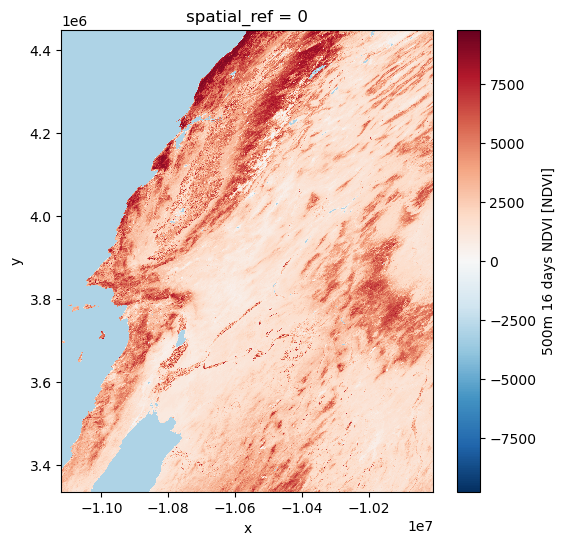

In [35]:
size = 6
aspect = data.rio.width/data.rio.height
data.plot.imshow(size = size,
                 aspect = aspect)

In [48]:
# get scale from the bands file
# accessed the first item of raster bands 
# then selected 'scale' from that
scale = item.assets["500m_16_days_NDVI"].extra_fields["raster:bands"][0]['scale']

In [50]:
# multiply these together to get the real ndvi values
ndvi = data*scale

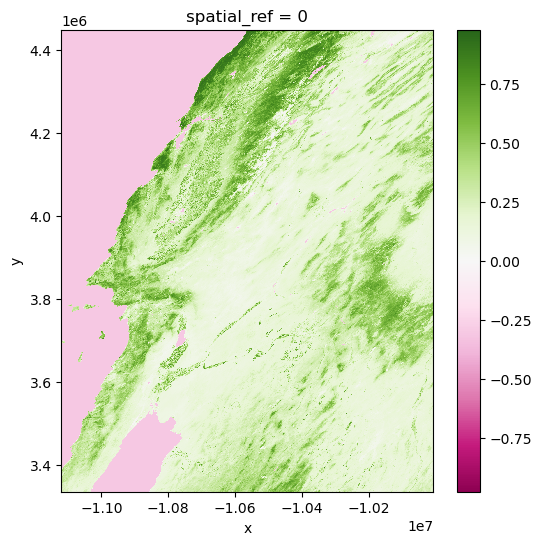

In [52]:
size = 6
aspect = ndvi.rio.width/ndvi.rio.height
ndvi.plot.imshow(size = size,
                 aspect = aspect,
                 cmap="PiYG")